# Import Libraries

In [19]:
import numpy as np
import pandas as pd
from packaging import version

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k
from keras import regularizers


In [20]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

# Verify TensorFlow Version and Keras Version

In [21]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2
print("Keras version: ", keras.__version__)

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2
Keras version:  2.9.0


# Research Assignment Reporting Functions

In [22]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

In [23]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [24]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

# Loading cifar10 Dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [8]:
print('train_images:\t{}'.format(x_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))

print('train_labels:\t{}'.format(y_train.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
test_images:		(10000, 32, 32, 3)
train_labels:	(50000, 1)
test_labels:		(10000, 1)


# Review Labels

In [9]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10])) 
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


# Preprocessing Data for Model Development

In [10]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

# Create Validation Data Set

In [11]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

# Confirm Datasets {Train, Validation, Test}

In [12]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


# Rescale Examples {Train, Validation, Test}

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255

1) Each element in each example is a pixel value
2) Pixel values range from 0 to 255
3) 0 = black
4) 255 = white

In [13]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

# # Build DNN Model EXPERIMENT 1 

2 layers (no regularization)

In [14]:
x_train.shape

(50000, 32, 32, 3)

In [15]:
DNNmodel1 = Sequential()
DNNmodel1.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
DNNmodel1.add(Dense(400, activation='relu'))
DNNmodel1.add(Dense(150, activation='relu'))
DNNmodel1.add(Dense(10, activation='softmax'))


In [16]:
DNNmodel1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 400)               1229200   
                                                                 
 dense_1 (Dense)             (None, 150)               60150     
                                                                 
 dense_2 (Dense)             (None, 10)                1510      
                                                                 
Total params: 1,290,860
Trainable params: 1,290,860
Non-trainable params: 0
_________________________________________________________________


In [17]:
DNNmodel1.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy', 
               metrics=['accuracy'])

# Training Model

In [18]:
history = DNNmodel1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=50
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)                                                                                                                          
                   )

Epoch 1/50
704/704 [==============================] - 21s 27ms/step - loss: 1.9014 - accuracy: 0.3203 - val_loss: 1.7557 - val_accuracy: 0.3716
Epoch 2/50
704/704 [==============================] - 10s 15ms/step - loss: 1.6911 - accuracy: 0.3931 - val_loss: 1.7223 - val_accuracy: 0.3734
Epoch 3/50
704/704 [==============================] - 10s 14ms/step - loss: 1.6129 - accuracy: 0.4223 - val_loss: 1.6438 - val_accuracy: 0.4184
Epoch 4/50
704/704 [==============================] - 10s 14ms/step - loss: 1.5532 - accuracy: 0.4460 - val_loss: 1.6183 - val_accuracy: 0.4180
Epoch 5/50
704/704 [==============================] - 10s 14ms/step - loss: 1.5109 - accuracy: 0.4617 - val_loss: 1.5864 - val_accuracy: 0.4262
Epoch 6/50
704/704 [==============================] - 10s 15ms/step - loss: 1.4753 - accuracy: 0.4750 - val_loss: 1.5569 - val_accuracy: 0.4480
Epoch 7/50
704/704 [==============================] - 10s 15ms/step - loss: 1.4519 - accuracy: 0.4854 - val_loss: 1.5442 - val_accuracy:

# Evaluate Model

In [25]:
print(f"Test acc: {DNNmodel1.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 5ms/step - loss: 1.5752 - accuracy: 0.4904
Test acc: 0.490


In [28]:
print(f"Train acc: {DNNmodel1.evaluate(x_train_norm, y_train_split)[1]:.3f}")

1407/1407 [==============================] - 7s 5ms/step - loss: 0.9715 - accuracy: 0.6548
Train acc: 0.655


In [29]:
print(f"Valid acc: {DNNmodel1.evaluate(x_valid_norm, y_valid_split)[1]:.3f}")

157/157 [==============================] - 1s 5ms/step - loss: 1.6173 - accuracy: 0.4856
Valid acc: 0.486


# Predictions

In [30]:
preds = DNNmodel1.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 4ms/step
shape of preds:  (10000, 10)


# Plotting Performance Metrics

In [31]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
45,1.020,0.635,1.575,0.491
46,1.017,0.636,1.584,0.483
47,1.010,0.639,1.574,0.495
48,0.999,0.642,1.581,0.493
49,1.000,0.642,1.617,0.486


# Plot Training Metrics (Loss and Accuracy)

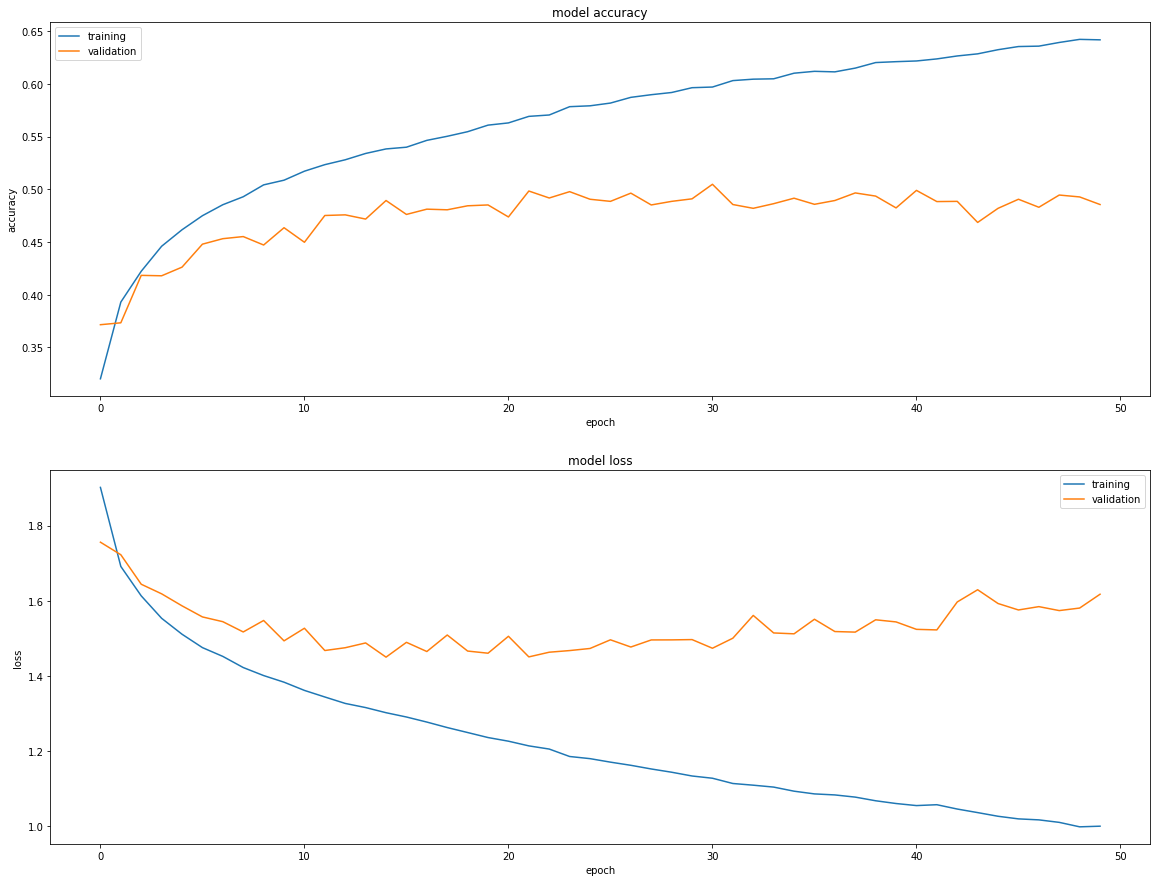

In [33]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

# Confusion matrices

In [34]:
pred1= DNNmodel1.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 4ms/step


In [35]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.55      0.55      0.55      1000
           1       0.59      0.60      0.60      1000
           2       0.43      0.32      0.37      1000
           3       0.33      0.27      0.30      1000
           4       0.38      0.46      0.41      1000
           5       0.39      0.41      0.40      1000
           6       0.52      0.54      0.53      1000
           7       0.53      0.59      0.56      1000
           8       0.63      0.62      0.62      1000
           9       0.53      0.54      0.53      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000

Accuracy Score: 0.4904
Root Mean Square Error: 3.0736460433823543


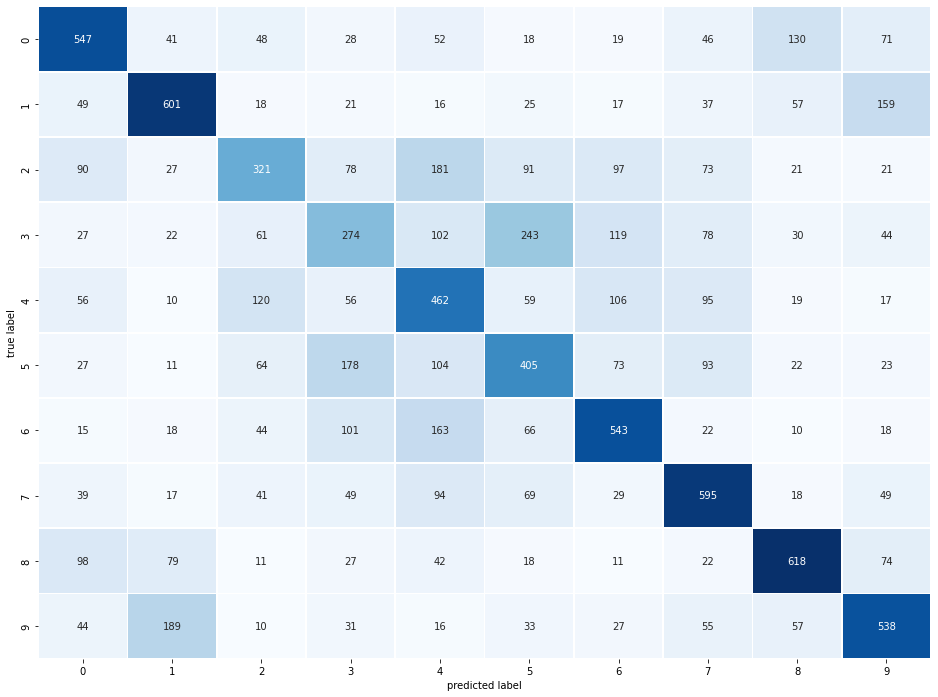

In [36]:
plot_confusion_matrix(y_test,pred1)

# # Build DNN Model EXPERIMENT 2
3 layers (no regularization)

In [50]:
DNNmodel2 = Sequential()
DNNmodel2.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
DNNmodel2.add(Dense(400, activation='relu'))
DNNmodel2.add(Dense(150, activation='relu'))
DNNmodel2.add(Dense(75, activation='relu'))
DNNmodel2.add(Dense(10, activation='softmax'))

In [51]:
DNNmodel2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_7 (Dense)             (None, 400)               1229200   
                                                                 
 dense_8 (Dense)             (None, 150)               60150     
                                                                 
 dense_9 (Dense)             (None, 75)                11325     
                                                                 
 dense_10 (Dense)            (None, 10)                760       
                                                                 
Total params: 1,301,435
Trainable params: 1,301,435
Non-trainable params: 0
_________________________________________________________________


In [52]:
DNNmodel2.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy', 
               metrics=['accuracy'])

In [53]:
history = DNNmodel2.fit(x_train_norm
                    ,y_train_split
                    ,epochs=50
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split),
                    callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False) 
                    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),                                                                                                                          
                    ])

Epoch 1/50
704/704 [==============================] - 11s 16ms/step - loss: 1.8833 - accuracy: 0.3216 - val_loss: 1.7245 - val_accuracy: 0.3882
Epoch 2/50
704/704 [==============================] - 11s 16ms/step - loss: 1.6883 - accuracy: 0.3945 - val_loss: 1.6612 - val_accuracy: 0.3940
Epoch 3/50
704/704 [==============================] - 11s 16ms/step - loss: 1.6079 - accuracy: 0.4250 - val_loss: 1.6050 - val_accuracy: 0.4246
Epoch 4/50
704/704 [==============================] - 11s 15ms/step - loss: 1.5457 - accuracy: 0.4482 - val_loss: 1.5950 - val_accuracy: 0.4302
Epoch 5/50
704/704 [==============================] - 19s 27ms/step - loss: 1.5081 - accuracy: 0.4602 - val_loss: 1.5443 - val_accuracy: 0.4366
Epoch 6/50
704/704 [==============================] - 11s 15ms/step - loss: 1.4818 - accuracy: 0.4703 - val_loss: 1.5183 - val_accuracy: 0.4542
Epoch 7/50
704/704 [==============================] - 11s 16ms/step - loss: 1.4507 - accuracy: 0.4811 - val_loss: 1.5018 - val_accuracy:

#Evaluate Model

In [54]:
print(f"Test acc: {DNNmodel2.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 1.4419 - accuracy: 0.4936
Test acc: 0.494


In [55]:
print(f"Train acc: {DNNmodel2.evaluate(x_train_norm, y_train_split)[1]:.3f}")

1407/1407 [==============================] - 7s 5ms/step - loss: 1.2014 - accuracy: 0.5713
Train acc: 0.571


In [56]:
print(f"Valid acc: {DNNmodel2.evaluate(x_valid_norm, y_valid_split)[1]:.3f}")

157/157 [==============================] - 1s 5ms/step - loss: 1.4606 - accuracy: 0.4826
Valid acc: 0.483


# Predictions

In [57]:
preds = DNNmodel2.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 2s 5ms/step
shape of preds:  (10000, 10)


# Plotting Performance Metrics

In [58]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [59]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
13,1.301,0.535,1.457,0.481
14,1.283,0.543,1.432,0.490
15,1.269,0.547,1.477,0.478
16,1.252,0.552,1.456,0.483
17,1.227,0.563,1.461,0.483


# Plot Training Metrics (Loss and Accuracy)

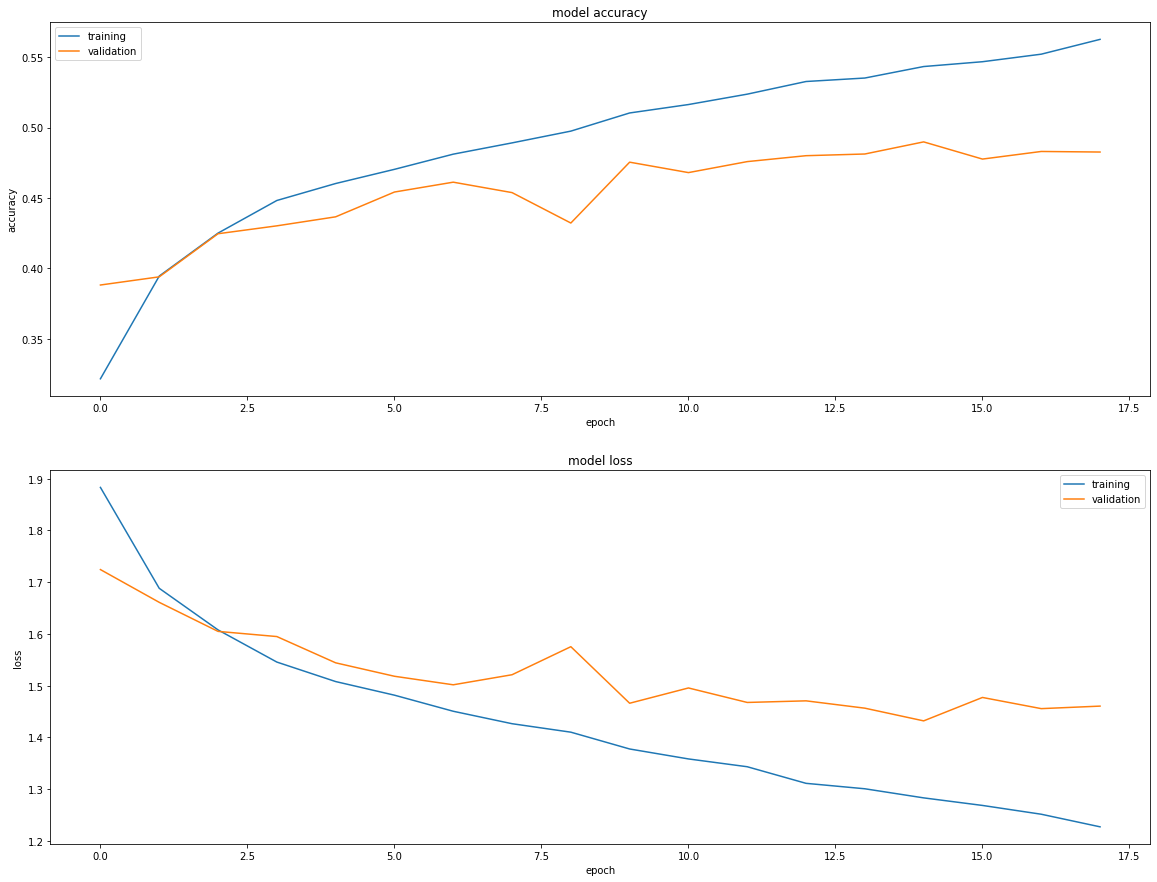

In [60]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

# Confusion matrices

In [61]:
pred1= DNNmodel2.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 5ms/step


In [62]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.51      0.57      1000
           1       0.67      0.53      0.59      1000
           2       0.38      0.35      0.37      1000
           3       0.30      0.36      0.33      1000
           4       0.42      0.43      0.43      1000
           5       0.35      0.49      0.40      1000
           6       0.53      0.54      0.53      1000
           7       0.67      0.47      0.55      1000
           8       0.60      0.70      0.64      1000
           9       0.58      0.56      0.57      1000

    accuracy                           0.49     10000
   macro avg       0.51      0.49      0.50     10000
weighted avg       0.51      0.49      0.50     10000

Accuracy Score: 0.4936
Root Mean Square Error: 2.9510676034276138


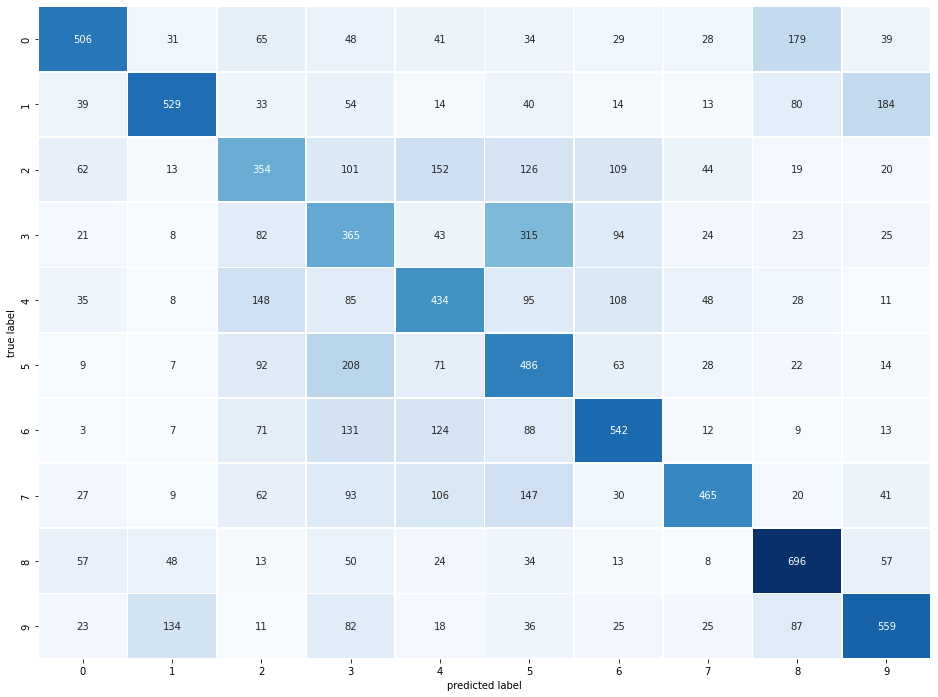

In [63]:
plot_confusion_matrix(y_test,pred1)

# Build DNN Model EXPERIMENT 1 with Regularization
2 layers (with regularization)

In [64]:
DNNmodel1reg = Sequential()
DNNmodel1reg.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
DNNmodel1reg.add(Dense(400, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
DNNmodel1reg.add(Dense(150, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
DNNmodel1reg.add(Dense(10, activation='softmax'))

In [65]:
DNNmodel1reg.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_11 (Dense)            (None, 400)               1229200   
                                                                 
 dense_12 (Dense)            (None, 150)               60150     
                                                                 
 dense_13 (Dense)            (None, 10)                1510      
                                                                 
Total params: 1,290,860
Trainable params: 1,290,860
Non-trainable params: 0
_________________________________________________________________


In [66]:
DNNmodel1reg.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy', 
               metrics=['accuracy'])

# Training Model

In [67]:
history = DNNmodel1reg.fit(x_train_norm
                    ,y_train_split
                    ,epochs=50
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)                                                                                                                          
                   )

Epoch 1/50
704/704 [==============================] - 16s 21ms/step - loss: 1.9550 - accuracy: 0.3191 - val_loss: 1.8249 - val_accuracy: 0.3536
Epoch 2/50
704/704 [==============================] - 14s 19ms/step - loss: 1.7390 - accuracy: 0.3875 - val_loss: 1.7404 - val_accuracy: 0.3782
Epoch 3/50
704/704 [==============================] - 14s 21ms/step - loss: 1.6509 - accuracy: 0.4210 - val_loss: 1.6235 - val_accuracy: 0.4270
Epoch 4/50
704/704 [==============================] - 13s 18ms/step - loss: 1.5996 - accuracy: 0.4393 - val_loss: 1.7046 - val_accuracy: 0.4106
Epoch 5/50
704/704 [==============================] - 13s 19ms/step - loss: 1.5548 - accuracy: 0.4573 - val_loss: 1.6025 - val_accuracy: 0.4446
Epoch 6/50
704/704 [==============================] - 13s 19ms/step - loss: 1.5300 - accuracy: 0.4681 - val_loss: 1.6020 - val_accuracy: 0.4402
Epoch 7/50
704/704 [==============================] - 13s 19ms/step - loss: 1.5091 - accuracy: 0.4777 - val_loss: 1.6430 - val_accuracy:

# Evaluate Model

In [68]:
print(f"Test acc: {DNNmodel1reg.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 6ms/step - loss: 1.5586 - accuracy: 0.5040
Test acc: 0.504


In [69]:
print(f"Train acc: {DNNmodel1reg.evaluate(x_train_norm, y_train_split)[1]:.3f}")

1407/1407 [==============================] - 8s 6ms/step - loss: 1.2479 - accuracy: 0.5934
Train acc: 0.593


In [70]:
print(f"Valid acc: {DNNmodel1reg.evaluate(x_valid_norm, y_valid_split)[1]:.3f}")

157/157 [==============================] - 1s 6ms/step - loss: 1.5763 - accuracy: 0.4904
Valid acc: 0.490


# Predictions

In [71]:
preds = DNNmodel1reg.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 4ms/step
shape of preds:  (10000, 10)


# Plotting Performance Metrics

In [72]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [73]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
45,1.277,0.577,1.521,0.502
46,1.265,0.583,1.590,0.490
47,1.259,0.585,1.543,0.505
48,1.248,0.590,1.594,0.492
49,1.258,0.585,1.576,0.490


# Plot Training Metrics (Loss and Accuracy)

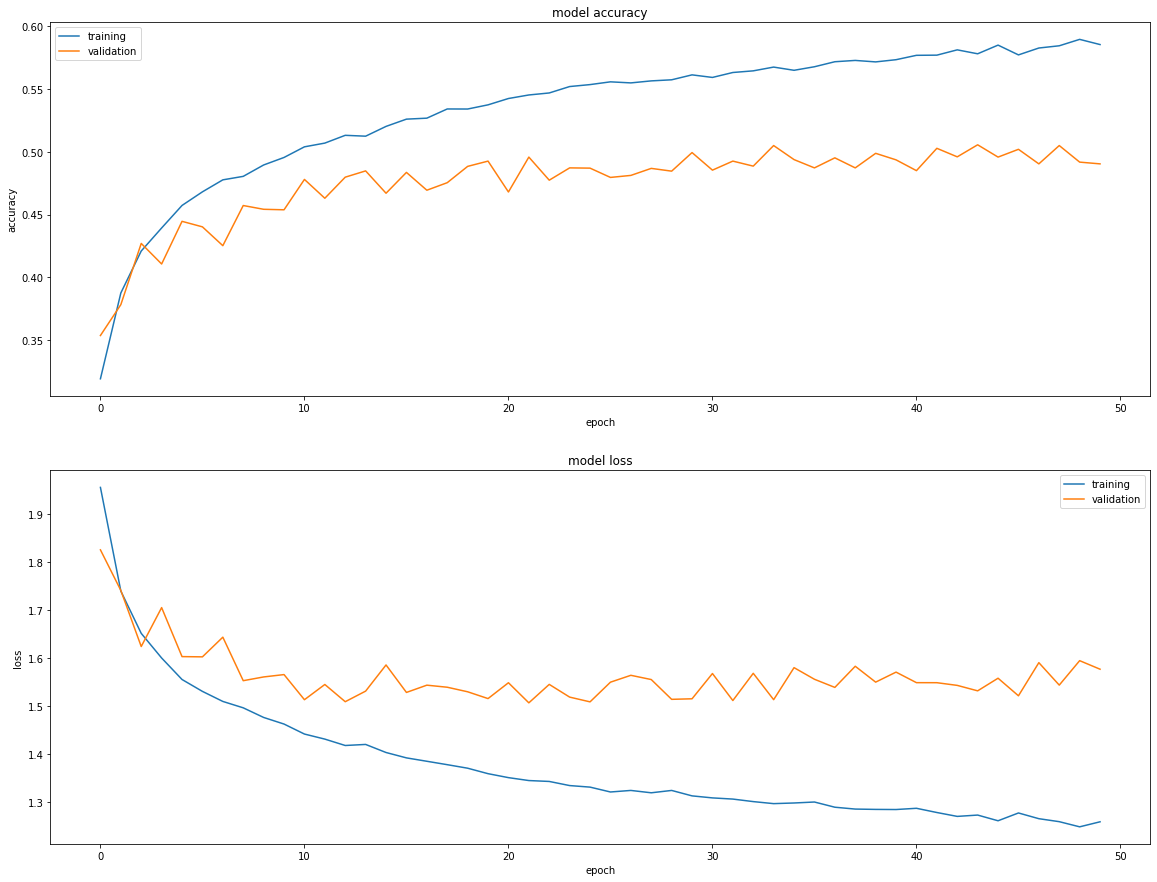

In [74]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

# Confusion matrices

In [75]:
pred1= DNNmodel1reg.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 5ms/step


In [76]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.44      0.70      0.54      1000
           1       0.66      0.56      0.61      1000
           2       0.38      0.45      0.41      1000
           3       0.39      0.28      0.33      1000
           4       0.51      0.36      0.43      1000
           5       0.46      0.39      0.42      1000
           6       0.56      0.56      0.56      1000
           7       0.55      0.55      0.55      1000
           8       0.63      0.54      0.58      1000
           9       0.52      0.64      0.57      1000

    accuracy                           0.50     10000
   macro avg       0.51      0.50      0.50     10000
weighted avg       0.51      0.50      0.50     10000

Accuracy Score: 0.504
Root Mean Square Error: 3.2044812372675864


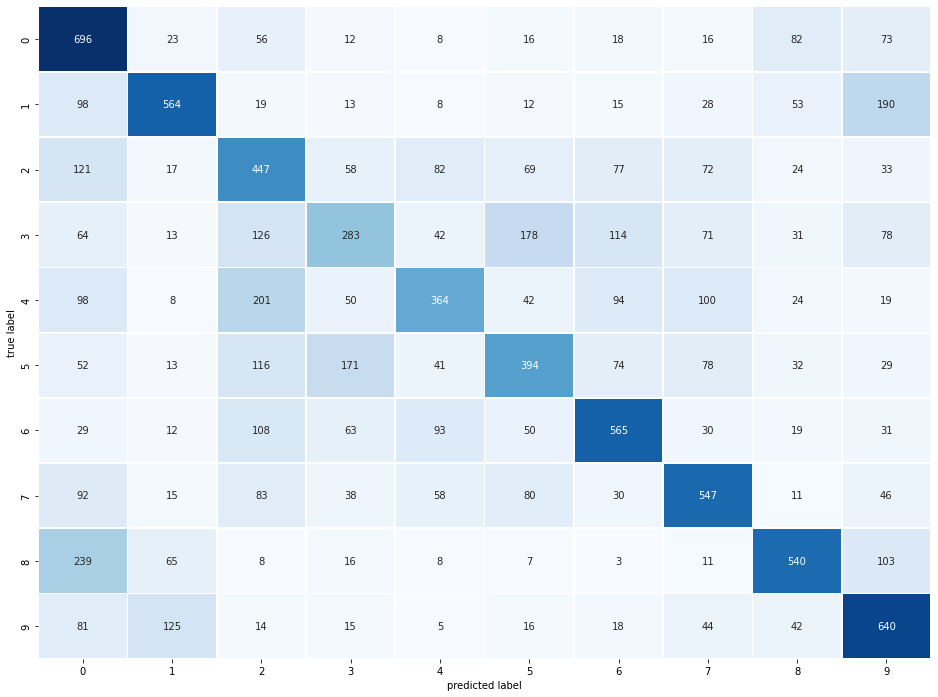

In [77]:
plot_confusion_matrix(y_test,pred1)

# Build DNN Model EXPERIMENT 2 Reg
3 layers (with regularization)

In [78]:
DNNmodel2reg = Sequential()
DNNmodel2reg.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
DNNmodel2reg.add(Dense(400, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
DNNmodel2reg.add(Dense(150, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
DNNmodel2reg.add(Dense(75, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
DNNmodel2reg.add(Dense(10, activation='softmax'))

In [79]:
DNNmodel2reg.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 3072)              0         
                                                                 
 dense_14 (Dense)            (None, 400)               1229200   
                                                                 
 dense_15 (Dense)            (None, 150)               60150     
                                                                 
 dense_16 (Dense)            (None, 75)                11325     
                                                                 
 dense_17 (Dense)            (None, 10)                760       
                                                                 
Total params: 1,301,435
Trainable params: 1,301,435
Non-trainable params: 0
_________________________________________________________________


In [80]:
DNNmodel2reg.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy', 
               metrics=['accuracy'])

# Training Model

In [82]:
history = DNNmodel2reg.fit(x_train_norm
                    ,y_train_split
                    ,epochs=50
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split),
                    callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False) 
                    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),                                                                                                                           
                    ])

Epoch 1/50
704/704 [==============================] - 14s 20ms/step - loss: 1.4321 - accuracy: 0.5085 - val_loss: 1.5164 - val_accuracy: 0.4864
Epoch 2/50
704/704 [==============================] - 14s 20ms/step - loss: 1.4183 - accuracy: 0.5124 - val_loss: 1.5668 - val_accuracy: 0.4588
Epoch 3/50
704/704 [==============================] - 14s 20ms/step - loss: 1.4111 - accuracy: 0.5180 - val_loss: 1.6028 - val_accuracy: 0.4308
Epoch 4/50
704/704 [==============================] - 14s 19ms/step - loss: 1.4024 - accuracy: 0.5213 - val_loss: 1.5298 - val_accuracy: 0.4822


# Evaluate Model

In [83]:
print(f"Test acc: {DNNmodel2reg.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 6ms/step - loss: 1.5057 - accuracy: 0.4848
Test acc: 0.485


In [84]:
print(f"Train acc: {DNNmodel2reg.evaluate(x_train_norm, y_train_split)[1]:.3f}")

1407/1407 [==============================] - 8s 6ms/step - loss: 1.3668 - accuracy: 0.5325
Train acc: 0.533


In [85]:
print(f"Valid acc: {DNNmodel2reg.evaluate(x_valid_norm, y_valid_split)[1]:.3f}")

157/157 [==============================] - 1s 6ms/step - loss: 1.5298 - accuracy: 0.4822
Valid acc: 0.482


# Predictions

In [86]:
preds = DNNmodel2reg.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 4ms/step
shape of preds:  (10000, 10)


# Plotting Performance Metrics

In [87]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [88]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,1.432,0.508,1.516,0.486
1,1.418,0.512,1.567,0.459
2,1.411,0.518,1.603,0.431
3,1.402,0.521,1.530,0.482


# Plot Training Metrics (Loss and Accuracy)

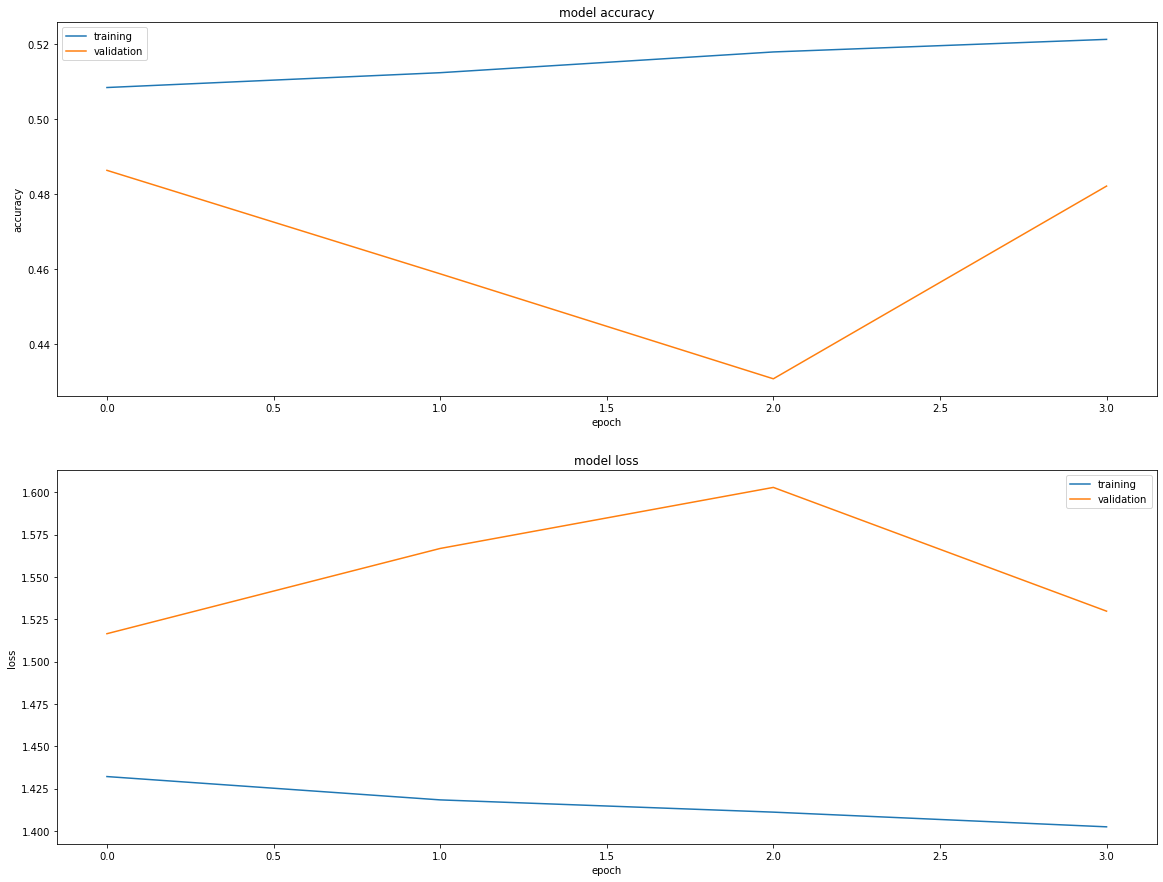

In [89]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

# Confusion matrices

In [90]:
pred1= DNNmodel2reg.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 4ms/step


In [91]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.60      0.47      0.53      1000
           1       0.51      0.71      0.60      1000
           2       0.53      0.20      0.29      1000
           3       0.35      0.30      0.32      1000
           4       0.40      0.47      0.43      1000
           5       0.45      0.30      0.36      1000
           6       0.42      0.69      0.52      1000
           7       0.61      0.50      0.55      1000
           8       0.51      0.74      0.60      1000
           9       0.54      0.47      0.50      1000

    accuracy                           0.48     10000
   macro avg       0.49      0.48      0.47     10000
weighted avg       0.49      0.48      0.47     10000

Accuracy Score: 0.4848
Root Mean Square Error: 3.1468714622621623


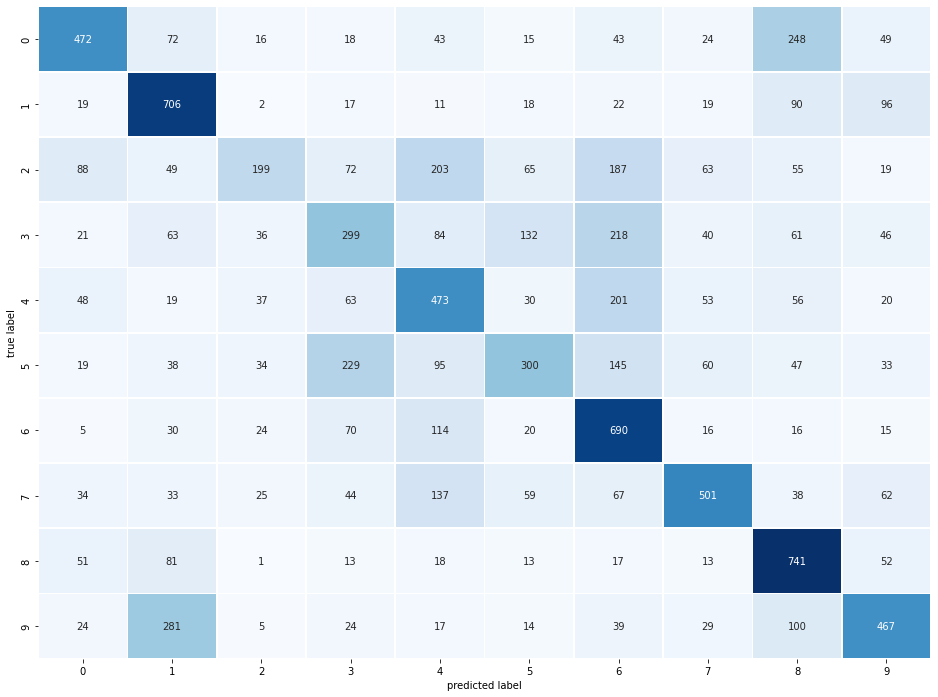

In [92]:
plot_confusion_matrix(y_test,pred1)